In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ofa.model_zoo import ofa_net

from MemSE.nas.CrossbarConstraint import c1_solver, c2_solver, dnn_to_memristor_shapes

torch.backends.cudnn.benchmark = True
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

ofa = ofa_net("ofa_resnet50", pretrained=True)

/home/sebwood/projects/def-franlp/sebwood/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
res = []
for _ in range(1000):
    ofa.sample_active_subnet()
    net = ofa.get_active_subnet() # try with get_active_net_config ?
    for n in dnn_to_memristor_shapes(net, cut=False):
        res.append(n)

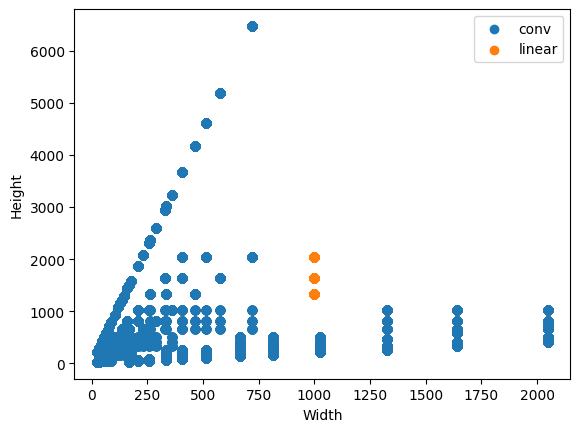

In [3]:
plt.scatter([d['w'] for d in res if d['layer_type'] == 'conv'], [d['h'] for d in res if d['layer_type'] == 'conv'], label='conv')
plt.scatter([d['w'] for d in res if d['layer_type'] == 'linear'], [d['h'] for d in res if d['layer_type'] == 'linear'], label='linear')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend()
plt.show()

In [3]:
config_crossbars = {'nb_crossbars':64, 'max_height':512, 'max_width':512}
total = 1e3
valids_c1 = 0
for _ in range(int(total)):
    ofa.sample_active_subnet()
    net = ofa.get_active_subnet()
    if c1_solver(net, **config_crossbars):
        valids_c1 += 1
        #c2_solver(net, **config_crossbars)
print('Proportion of valids C1=', valids_c1/total)

Proportion of valids C1= 0.009


In [2]:
ofa.set_active_subnet(
            d=min(ofa.depth_list),
            e=min(ofa.expand_ratio_list),
            w=0,
        )
net = ofa.get_active_subnet()
if c1_solver(net, verbose=True, nb_crossbars=64, max_height=512, max_width=512):
    c2_solver(net, nb_crossbars=64, max_height=512, max_width=512)
    
# ofa.set_max_net()
# net = ofa.get_active_subnet()
# if c1_solver(net, verbose=True, nb_crossbars=1024):
#     c2_solver(net, nb_crossbars=1024)

C1 checks capa=True
Capacity 13032928 required - 16777216 available
Preallocated 4 full crossbars (x2 for negatives)
Now allocating 52 partial weights (x2 for negatives)
Solution 0, time = 17.495736837387085 s

Statistics
  conflicts      : 2582
  branches       : 40702
  wall time      : 17.523722912 s
  solutions found: 1


Preallocated 4 full crossbars (x2 for negatives)
Now allocating 64 partial weights (x2 for negatives)
Solution 0, time = 37.13684010505676 s

Statistics
  conflicts      : 2061
  branches       : 42205
  wall time      : 37.153268455 s
  solutions found: 1


AttributeError: 'Tetristalloc' object has no attribute '__rectangles'

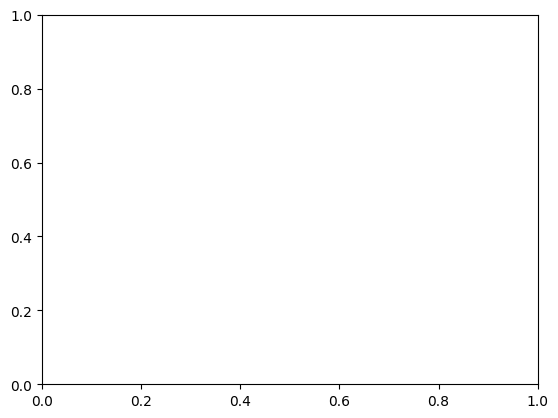

In [3]:
plotter = None
config_crossbars = {'nb_crossbars':64, 'max_height':512, 'max_width':512}
max_tries = 1e3
t = 0
while t < max_tries:
    t += 1
    ofa.sample_active_subnet()
    net = ofa.get_active_subnet()
    r = c1_solver(net, **config_crossbars)
    if r:
        plotter = c2_solver(net, **config_crossbars)
        if plotter.solution_count() > 0:
            break
        
fig, ax = plt.subplots() # https://www.geeksforgeeks.org/python-pil-imagedraw-draw-rectangle/ otherwise
for rect in plotter.__rectangles:
    ax.add_patch(Rectangle(rect[0], rect[1], rect[2],
             edgecolor = 'pink',
             facecolor = 'blue',
             fill=True,
             lw=1))

plt.show()